# Image Classification

## Section 0. Download dataset.

In [1]:
import cv2
import os
import random
import numpy as np
from pathlib import Path
import urllib.request
import zipfile
import urllib
import hashlib
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from google.colab.patches import cv2_imshow

random.seed(0)
np.random.seed(0)

In [2]:
def download_data(data_dir):
    """    
    Args:
        data_dir (Path): Path to the download and extract data directory.

    Returns:
        xs_train: (num_train, 32, 32, 3) uint8
        ys_train: (num_train, ) uint8
        xs_test: (num_test, 32, 32, 3) uint8
    """

    class DownloadProgressBar(tqdm):

        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    def compute_md5(file_path):
        file_path = Path(file_path)
        if not file_path.is_file():
            raise ValueError(f"File {file_path} does not exist.")

        with open(file_path, "rb") as f:
            file_hash = hashlib.md5()
            chunk = f.read(8192)
            while chunk:
                file_hash.update(chunk)
                chunk = f.read(8192)

        return str(file_hash.hexdigest())

    def maybe_download_url(url, output_path, md5sum=None):
        output_path = Path(output_path)

        if output_path.is_file() and md5sum is not None:
            if compute_md5(output_path) == md5sum:
                print(f"{output_path} exists and MD5 matches. Skip download.")
                return

        with DownloadProgressBar(unit='B',
                                 unit_scale=True,
                                 miniters=1,
                                 desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)

    # Paths
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)
    zip_path = data_dir / "data.zip"
    url = "https://github.com/comp3314/hw3-data/releases/download/hw3/data.zip"
    md5sum = "bd4f13ea7b8d9b79c1320fe559698dbd"

    # Download URL
    maybe_download_url(url, zip_path, md5sum=md5sum)

    # Extract zip
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as f:
        f.extractall(data_dir)
    print("Extracting done.")


def load_data(data_dir):
    data_dir = Path(data_dir)
    if not data_dir.is_dir():
        raise ValueError(f"{data_dir} is not a directory.")

    # Read train
    train_dir = data_dir / "train"
    train_label_path = train_dir / "labels.txt"
    xs_train = []
    ys_train = []
    with open(train_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read train"):
        im_path, im_label = line.split(" ")
        im_path = train_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_train.append(im_rgb)
        ys_train.append(int(im_label))

    # Read test
    test_dir = data_dir / "test"
    test_label_path = test_dir / "labels.txt"
    xs_test = []
    with open(test_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read test"):
        im_path = line
        im_path = test_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_test.append(im_rgb)

    xs_train = np.array(xs_train, dtype=np.uint8)
    ys_train = np.array(ys_train)
    xs_test = np.array(xs_test, dtype=np.uint8)

    return xs_train, ys_train, xs_test

data_dir="data"
download_data(data_dir=data_dir)
xs_train, ys_train, xs_test = load_data(data_dir=data_dir)

xs_train = np.array(xs_train)
ys_train = np.array(ys_train)
xs_test = np.array(xs_test)

print('xs_train: ', xs_train.shape)
print('ys_train: ', ys_train.shape)
print('xs_test: ', xs_test.shape)

data/data.zip exists and MD5 matches. Skip download.
Extracting...
Extracting done.


Read test: 100%|██████████| 10000/10000 [00:00<00:00, 12354.07it/s]


xs_train:  (50000, 32, 32, 3)
ys_train:  (50000,)
xs_test:  (10000, 32, 32, 3)


## Section 1. Dataset preparation.

Before dealing with a new dataset, it is important to know the basic information of the data. 

### Section 1.1. How many categories does this dataset cover?

In [3]:
categories = np.unique(ys_train)
print(f"This dataset has {len(categories)} different categories")
print(f"They are: {categories}")

This dataset has 10 different categories
They are: [0 1 2 3 4 5 6 7 8 9]


### Section 1.2. How many train/test samples does each category contain?

In [4]:
counts = np.bincount(ys_train)

for category in categories:
  num_of_samples = counts[category ]
  print(f"Category {category} contains {num_of_samples} train samples")

print("\nFrom this, we can infer that each category has (10,000 / 10) = 1000 samples in the test set")

Category 0 contains 5000 train samples
Category 1 contains 5000 train samples
Category 2 contains 5000 train samples
Category 3 contains 5000 train samples
Category 4 contains 5000 train samples
Category 5 contains 5000 train samples
Category 6 contains 5000 train samples
Category 7 contains 5000 train samples
Category 8 contains 5000 train samples
Category 9 contains 5000 train samples

From this, we can infer that each category has (10,000 / 10) = 1000 samples in the test set


### Section 1.3. Visualize one sample for each category.

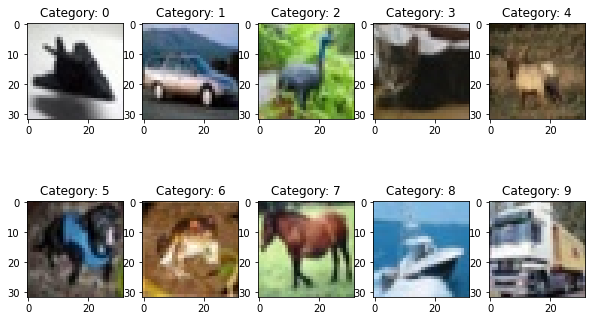

In [5]:
categories_list = list(categories)

fig = plt.figure(figsize=(10, 6))

for category in categories_list:
  for i in range(len(xs_train)):
    if ys_train[i] == category:
      ax = fig.add_subplot(2, 5, category+1)
      image = xs_train[i].reshape((32, 32, 3))
      ax.imshow(image)
      ax.set_title(f"Category: {category}")
      break

plt.show()

## Section 2.  Controlled experiments.

### Helper Functions

In [6]:
# Displaying a random image

def display_image(initials, transformed):
  print("Initial Image")
  cv2_imshow(initials[50])

  print("\nTransformed Image")
  cv2_imshow(transformed[50])

In [7]:
# Adjusting the dimensions of our train set and splitting it into training and validation sets

def reshape_and_split_data(x, y):
  # Reshaping
  dim1 = x.shape[0]
  dim2 = 1
  for i in range(1, len(x.shape)):
    dim2 *= x.shape[i]

  reshaped_x = x.reshape((dim1, dim2))
  print("x reshaped into: ", reshaped_x.shape)

  # Splitting
  x_train, x_val, y_train, y_val = train_test_split(reshaped_x, y, test_size=0.33, random_state=42)

  print("\nx_train shape: ", x_train.shape)
  print("y_train shape: ", y_train.shape)
  print("\nx_val shape: ", x_val.shape)
  print("y_val shape: ", y_val.shape)

  return x_train, x_val, y_train, y_val

### Section 2.1. Controlled experiment I.

#### Feature Extraction and Engineering

##### Making images grayscale to reduce computational complexity

Initial Image


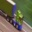


Transformed Image


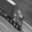


Shape of grayscale train data is:  (50000, 32, 32)


In [8]:
# making images grayscale

def make_gray(x):
  gray_images = []

  for img in x:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)

  gray_x = np.array(gray_images)

  return gray_x

gray_xs_train = make_gray(xs_train)

# printing a sample image for displaying grayscale
display_image(xs_train, gray_xs_train)

print("\nShape of grayscale train data is: ", gray_xs_train.shape)

##### Blurring images to remove noise

Initial Image


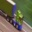


Transformed Image


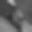


Shape of blurred train data is:  (50000, 32, 32)


In [9]:
# Blurring images

def make_blur(x):
  blurred_images = []

  for img in x:
    blur = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)
    blurred_images.append(blur)

  blur_x = np.array(blurred_images)

  return blur_x

blur_xs_train = make_blur(gray_xs_train)

# printing a sample image for displaying blurred
display_image(xs_train, blur_xs_train)

print("\nShape of blurred train data is: ", blur_xs_train.shape)

##### Edge detection using the canny algorithm to identify objects

Initial Image


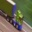


Transformed Image


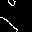


Shape of canny train data is:  (50000, 32, 32)


In [10]:
# Canny edge detection

def make_canny(x):
  canny_images = []

  for img in x:
    canny = cv2.Canny(img, 100, 200)
    canny_images.append(canny)

  canny_x = np.array(canny_images)

  return canny_x

canny_xs_train = make_canny(blur_xs_train)

# printing a sample image for displaying canny images
display_image(xs_train, canny_xs_train)

print("\nShape of canny train data is: ", canny_xs_train.shape)

##### Identifying contours in a hierarchical manner to understand the order and arrangement of objects in the image

Initial Image


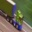


Transformed Image


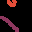


Shape of contour train data is:  (50000, 32, 32, 3)


In [11]:
# Getting contours
# Some part of code taken from OpenCV docs: https://docs.opencv.org/4.x/df/d0d/tutorial_find_contours.html

def make_contours(x):
  contour_images = []

  for img in x:
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
          color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
          cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
    contour_images.append(drawing)

  contour_x = np.array(contour_images)

  return contour_x

contour_xs_train = make_contours(canny_xs_train)

# printing a sample image for displaying contour images
display_image(xs_train, contour_xs_train)

print("\nShape of contour train data is: ", contour_xs_train.shape)

##### Generating Histogram of Oriented Gradients (HOG) to refine the edge detection process and determine the local, underlying relationships between points in the image

Initial Image


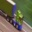


Transformed Image


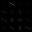


Shape of HOG train data is:  (50000, 32, 32)


In [12]:
# Histogram of Oriented Gradients (HOG)

def make_hog(x):
  hog_images = []

  for img in x:
    fd, drawing = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_images.append(drawing)

  hog_x = np.array(hog_images)

  return hog_x

hog_xs_train = make_hog(gray_xs_train)

# printing a sample image for displaying HOG images
display_image(xs_train, hog_xs_train)

print("\nShape of HOG train data is: ", hog_xs_train.shape)

##### Splitting the preprocessed data into train and validation sets using the holdout method

In [13]:
# Splitting into train and validation sets

x_train, x_val, y_train, y_val = reshape_and_split_data(hog_xs_train, ys_train)

x reshaped into:  (50000, 1024)

x_train shape:  (33500, 1024)
y_train shape:  (33500,)

x_val shape:  (16500, 1024)
y_val shape:  (16500,)


##### Standardizing the images down to a uniform scale

In [14]:
# Standardization for uniformly scaling all the data

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_val_std = sc.transform(x_val)
print("After standardization, shapes are:")
print("x_train: ", x_train_std.shape)
print("x_val: ", x_val_std.shape)

After standardization, shapes are:
x_train:  (33500, 1024)
x_val:  (16500, 1024)


##### Getting rid of unnecessary features to focus only on the significant ones and reduce computational complexity using Principle Component Analysis (PCA)

In [57]:
# PCA for getting only highly meaningful features with 0.90 ratio of variance 

pca = PCA(n_components=0.90)
pca.fit(x_train_std)
x_train_pca = pca.fit_transform(x_train_std)
x_val_pca = pca.transform(x_val_std)
print("After PCA, shapes are:")
print("x_train: ", x_train_pca.shape)
print("x_val: ", x_val_pca.shape)

After PCA, shapes are:
x_train:  (33500, 69)
x_val:  (16500, 69)


### Section 2.2. Controlled experiment II.

#### Trying a simple KNN with minkowski as the metric for distance and 5 neighbors

In [61]:
# K Nearest Neighbours

from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN(n_neighbors=5, p=2, metric="minkowski")
knn.fit(x_train_pca, y_train)
knn_pred_train = knn.predict(x_train_pca)
knn_train_acc = accuracy_score(y_true=y_train, y_pred=knn_pred_train)
print("KNN training accuracy: ", knn_train_acc)

knn_pred_val = knn.predict(x_val_pca)
knn_val_acc = accuracy_score(y_true=y_val, y_pred=knn_pred_val)
print("KNN validation accuracy: ", knn_val_acc)

KNN training accuracy:  0.6382686567164179
KNN validation accuracy:  0.4713333333333333


### Section 2.3. Controlled experiment III.

#### Trying out an MLP with 5 hidden layers, each with 200 nodes. The activation function used is ReLU with Adam optimizer.

In [19]:
# MLP

mlp = MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200, 200), activation="relu", solver="adam", learning_rate_init=0.001)
mlp.fit(x_train_std, y_train)
mlp_pred_train = mlp.predict(x_train_std)
mlp_train_acc = accuracy_score(y_true=y_train, y_pred=mlp_pred_train)
print("MLP training accuracy: ", mlp_train_acc)

mlp_pred_val = mlp.predict(x_val_std)
mlp_val_acc = accuracy_score(y_true=y_val, y_pred=mlp_pred_val)
print("MLP validation accuracy: ", mlp_val_acc)

MLP training accuracy:  0.9860298507462687
MLP validation accuracy:  0.546


## Section 3. Final Model

Building the final image classification model. This model will be used to predict the official test set.

##### Helper Function for final pipeline

In [15]:
def final_preprocessing_pipeline(x):
  grays = make_gray(x)
  hogs = make_hog(grays)

  # Reshaping
  dim1 = hogs.shape[0]
  dim2 = 1
  for i in range(1, len(hogs.shape)):
    dim2 *= hogs.shape[i]

  reshaped_x = hogs.reshape((dim1, dim2))

  return reshaped_x

##### Preparing training data

In [16]:
# Preparing the entire training dataset

# Doing feature extraction and engineering
engineered_xs_train = final_preprocessing_pipeline(xs_train)

# Standardizing it
sc = StandardScaler()
xs_train_final = sc.fit_transform(engineered_xs_train)

print("The final training dataset's shape is: \n")
print(xs_train_final.shape)

print("\nThe final training dataset is: \n")
xs_train_final

The final training dataset's shape is: 

(50000, 1024)

The final training dataset is: 



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Preparing testing data

In [17]:
# Preparing testing data

# Doing feature extraction and engineering
engineered_xs_test = final_preprocessing_pipeline(xs_test)

# Standardizing it
xs_test_final = sc.transform(engineered_xs_test)

print("The final testing dataset's shape is: \n")
print(xs_test_final.shape)

print("The final testing dataset is: \n")
xs_test_final

The final testing dataset's shape is: 

(10000, 1024)
The final testing dataset is: 



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Running the final model

In [20]:
# Running the final model with all requisites met

model = mlp
model.fit(xs_train_final, ys_train)
ys_test_pred = model.predict(xs_test_final)
print("The predicted results are: \n")
ys_test_pred

The predicted results are: 



array([1, 4, 7, ..., 6, 3, 1])

## Section 4. Report the result

### 4.3 Getting predictions on the test set

In [21]:
def save_submission_results(ys_test_pred, uid="UID"):
    """    
    Args:
        ys_test_pred: numpy array of shape (num_tests, )
        uid: student's UID. 
    """
    num_tests = 10000
    assert isinstance(ys_test_pred, np.ndarray)
    assert ys_test_pred.shape == (num_tests, )
    
    out_path = f"pred_{uid}.txt"
    with open(out_path, "w") as f:
        for idx, y_pred in enumerate(ys_test_pred):
            im_name = f"test_{idx:05d}.jpg"
            f.write(f"{im_name} {y_pred}\n")
    
    print(f"Result written to {out_path}")

In [22]:
save_submission_results(ys_test_pred, uid="3035832751")

Result written to pred_3035832751.txt
